<a href="https://colab.research.google.com/github/trungdvq/mta-lstm-pytorch/blob/master/mta_lstm_multi_layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MTA-LSTM-PyTorch

This is an implementation of the paper [Topic-to-Essay Generation with Neural Networks](http://ir.hit.edu.cn/~xcfeng/xiaocheng%20Feng's%20Homepage_files/final-topic-essay-generation.pdf). The original work can be found [here](https://github.com/hit-computer/MTA-LSTM), which is implemented in TensorFlow and is totally out-of-date, further more, the owner doesn't seem to maintain it anymore. Therefore, I decided to re-implement it in a simple yet powerful framework, PyTorch.

In this notebook, I'll show you how to build a neural network proposed in the paper step by step from scratch.

## Import packages

The followings are some packages that'll be used in this work. Make sure you have them installed.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import gensim
from gensim.models import KeyedVectors
import numpy as np
import torch
from torch import nn, autograd, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import Parameter, LayerNorm
from torch.autograd import Variable
import torch.jit as jit
import torch.nn.functional as F
import time
import os
import math
from tqdm import tqdm
import collections
from collections import namedtuple
import random

In [3]:
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# !wget "https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKtc-hinted.zip"
# !unzip NotoSansCJKtc-hinted.zip
# !sudo mv NotoSansCJKtc-Black.otf /usr/share/fonts/truetype/
# !sudo mv NotoSansCJKtc-Bold.otf /usr/share/fonts/truetype/
# !sudo mv NotoSansCJKtc-DemiLight.otf /usr/share/fonts/truetype/
# !sudo mv NotoSansCJKtc-Light.otf /usr/share/fonts/truetype/
# !sudo mv NotoSansCJKtc-Medium.otf /usr/share/fonts/truetype/
# !sudo mv NotoSansCJKtc-Regular.otf /usr/share/fonts/truetype/
# !sudo mv NotoSansCJKtc-Thin.otf /usr/share/fonts/truetype/
# !sudo mv NotoSansMonoCJKtc-Bold.otf /usr/share/fonts/truetype/
# !sudo mv NotoSansMonoCJKtc-Regular.otf /usr/share/fonts/truetype/

In [4]:
import matplotlib.font_manager as fm
import matplotlib.font_manager as font_manager
root_path = '/content/drive/MyDrive/ThacSi/mta-lstm-pytorch'
font_dirs = [root_path +'/fonts/', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)
path = 'NotoSansCJKtc-Regular.otf'
fontprop = fm.FontProperties(fname=path)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  


In [5]:
# os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print('Available cuda:', torch.cuda.device_count())
# if torch.cuda.is_available():
#     device_num = 1
#     deviceName = "cuda:%d" % device_num
#     torch.cuda.set_device(device_num)
#     print('Current device:', torch.cuda.current_device())
# else:
#     deviceName = "cpu"
    
# device = torch.device(deviceName)
def try_gpu(i=0):  #@save
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def try_all_gpus():  #@save
    """Return all available GPUs, or [cpu(),] if no GPU exists."""
    devices = [torch.device(f'cuda:{i}')
             for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]

device = try_all_gpus()
print (device)

1
Tesla T4
Available cuda: 1
[device(type='cuda', index=0)]


## Build a dictionary and pretrained embedding system

Here I'm gonna load the pretrained word2vec vocab and vectors. Please refer to [this notebook]() to he how to train it.

The code ```fvec.vectors``` is where we get the pretrained vectors.
```<PAD>```, ```<BOS>```, ```<EOS>``` and ```<UNK>``` are 4 common tokens which stands for **PADding**, **Begin-Of-Sentence**, **End-Of-Sentence** and **UNKnown** respectively. We simply add them into the vocabularies.

In [6]:
file_path = '/content/drive/MyDrive/ThacSi/mta-lstm-pytorch/data/'
fvec = KeyedVectors.load_word2vec_format(file_path+'composition_mincount_1_305000_vec_original.txt', binary=False)
word_vec = fvec.vectors
vocab = ['<PAD>', '<BOS>', '<EOS>', '<UNK>']
vocab.extend(list(fvec.vocab.keys()))
word_vec = np.concatenate((np.array([[0]*word_vec.shape[1]] * 4), word_vec))
word_vec = torch.tensor(word_vec).float()
del fvec
print("total %d words" % len(word_vec))

total 196849 words


In [7]:
model_path = '/content/drive/MyDrive/ThacSi/mta-lstm-pytorch/model/'
save_folder = model_path + 'model_result_multi_layer'
vocab_check_point = '%s/vocab.pkl' % save_folder
word_vec_check_point = '%s/word_vec.pkl' % save_folder
torch.save(vocab, vocab_check_point)
torch.save(word_vec, word_vec_check_point)


## Build a word-index convertor

We don't want to use type of string directly when training, instead we map them to a unique index in integer. In text generation phase, we'll then convert them back to string.

In [8]:
print (vocab)
word_to_idx = {ch: i for i, ch in enumerate(vocab)}
# print (word_to_idx)
idx_to_word = {i: ch for i, ch in enumerate(vocab)}
# print (idx_to_word)

['<PAD>', '<BOS>', '<EOS>', '<UNK>', 'the', ',', '.', 'to', 'of', 'a', 'and', 'in', '”', 'that', 'on', 'for', 'is', '“', 'was', 'with', 'as', 'it', 'he', 'said', 'at', 'his', 'by', 'from', 'has', 'have', 'an', 'be', 'are', 'but', 'not', 'this', 'trump', 'i', 'its', 'who', 'they', 'about', 'were', 'their', 'had', 'her', 'will', 'or', 'we', 'been', 'one', 'more', 'new', 'after', 'which', 'you', 'would', 'she', 'people', 'when', 'president', 'out', 'up', 'what', 'all', 'than', 'if', 'also', 'over', 'so', 'first', 'into', 'there', 'some', 'two', 'no', 'just', 'like', 'years', 'can', 'u.', 'last', 'other', '?', 'time', 's.', 'state', 'donald', 'him', 'told', 'our', 'could', 'now', 'clinton', 'them', 'most', 'news', 'year', 'how', 'house', 'states', 'us', 'do', 'trumps', 'according', 'before', 'because', 'many', 'my', 'even', 'while', 'campaign', 'percent', 'police', 'against', 'only', 'during', 'those', 'where', 'white', 'says', 'republican', 'week', 'made', 'since', 'any', 'may', 'american

## Load preprocessed data

You can prepare for your own data, or simply use what I offered in the data folder.

In [9]:
essays = []
topics = []
num_lines = sum(1 for line in open(file_path+'news_data.txt', 'r'))
with open(file_path+'news_data.txt') as f:
    for line in tqdm(f, total=num_lines):
        essay, topic = line.replace('\n', '').split(' </d> ')
        essays.append(essay.split(' '))
        topics.append(topic.split(' '))
    f.close()
    
assert len(topics) == len(essays)

100%|██████████| 130224/130224 [00:05<00:00, 22524.73it/s]


In [10]:
print (len(topics))
print (type(topics))
print (topics[0])

130224
<class 'list'>
['republican', 'administrations', 'health', 'care', 'political', 'trumps', 'insurance', 'states', 'huge', 'leaving', '']


We then map all the training and testing corpus to integer index word-by-word, with the help of our convertor. Note that we map it to ```<UNK>``` if the words in corpus are not in the dictionary.

In [11]:
corpus_indice = list(map(lambda x: [word_to_idx[w] if (w in word_to_idx) else word_to_idx['<UNK>'] for w in x], tqdm(essays[:300000])))
topics_indice = list(map(lambda x: [word_to_idx[w] if (w in word_to_idx) else word_to_idx['<UNK>'] for w in x], tqdm(topics[:300000])))
corpus_test = list(map(lambda x: [word_to_idx[w] if (w in word_to_idx) else word_to_idx['<UNK>'] for w in x], tqdm(essays[300000:305000])))
topics_test = list(map(lambda x: [word_to_idx[w] if (w in word_to_idx) else word_to_idx['<UNK>'] for w in x], tqdm(topics[300000:305000])))

100%|██████████| 130224/130224 [00:01<00:00, 82447.33it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [12]:
# fix cho tieng anh
corpus_indice = list(map(lambda x: [word_to_idx[w] if (w in word_to_idx) else word_to_idx['<UNK>'] for w in x], tqdm(essays[:120224])))
topics_indice = list(map(lambda x: [word_to_idx[w] if (w in word_to_idx) else word_to_idx['<UNK>'] for w in x], tqdm(topics[:120224])))
corpus_test = list(map(lambda x: [word_to_idx[w] if (w in word_to_idx) else word_to_idx['<UNK>'] for w in x], tqdm(essays[120224:130224])))
topics_test = list(map(lambda x: [word_to_idx[w] if (w in word_to_idx) else word_to_idx['<UNK>'] for w in x], tqdm(topics[120224:130224])))

100%|██████████| 10000/10000 [00:00<00:00, 184369.87it/s]


In [13]:
def viewData(topics, X):
    topics = [idx_to_word[x] for x in topics]
    X = [idx_to_word[x] for x in X]
    print(topics, X)

In [14]:
from random import shuffle

def shuffleData(topics_indice, corpus_indice):
    ind_list = [i for i in range(len(topics_indice))]
    shuffle(ind_list)
    topics_indice = np.array(topics_indice)
    corpus_indice = np.array(corpus_indice)
    topics_indice = topics_indice[ind_list,]
    corpus_indice = corpus_indice[ind_list,]
    topics_indice = topics_indice.tolist()
    corpus_indice = corpus_indice.tolist()
    return topics_indice, corpus_indice

# topics_indice, corpus_indice = shuffleData(topics_indice, corpus_indice)
viewData(topics_indice[0], corpus_indice[0])

['republican', 'administrations', 'health', 'care', 'political', 'trumps', 'insurance', 'states', 'huge', 'leaving', '<UNK>'] ['washington', 'congressional', 'republicans', 'have', 'a', 'new', 'fear', 'when', 'it', 'comes', 'to', 'their', 'health', 'care', 'lawsuit', 'against', 'the', 'obama', 'administration', 'they', 'might', 'win', '.', 'the', 'incoming', 'trump', 'administration', 'could', 'choose', 'to', 'no', 'longer', 'defend', 'the', 'executive', 'branch', 'against', 'the', 'suit', ',', 'which', 'challenges', 'the', 'administrations', 'authority', 'to', 'spend', 'billions', 'of', 'dollars', 'on', 'health', 'insurance', 'subsidies', 'for', 'and', 'americans', ',', 'handing', 'house', 'republicans', 'a', 'big', 'victory', 'on', 'issues', '.', 'but', 'a', 'sudden', 'loss', 'of', 'the', 'disputed', 'subsidies', 'could', 'conceivably', 'cause', 'the', 'health', 'care', 'program', 'to', 'implode', ',', 'leaving', 'millions', 'of', 'people', 'without', 'access', 'to', 'health', 'insur

In [41]:
for t in topics_indice:
        t += [3] * (11 - len(t))
        print('less of t is: {0} and value {1}'.format (len(t),t))

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
less of t is: 11 and value [1641, 134, 52, 3121, 60139, 1415, 1275, 23, 4945, 2385, 3]
less of t is: 11 and value [362, 842, 352, 4978, 1531, 1998, 345, 1246, 100, 341, 3]
less of t is: 11 and value [21405, 560, 1196, 2571, 4703, 3412, 3193, 13794, 6486, 119, 3]
less of t is: 11 and value [836, 733, 191, 470, 15180, 87, 185, 2000, 314, 52, 3]
less of t is: 11 and value [2264, 9714, 1575, 736, 89, 680, 302, 3014, 3, 3, 3]
less of t is: 11 and value [347, 77, 52, 178, 703, 1021, 191, 2312, 3115, 393, 3]
less of t is: 11 and value [103, 2860, 2337, 3193, 956, 683, 478, 81071, 213, 1506, 3]
less of t is: 11 and value [224, 178, 646, 250, 113, 15421, 562, 828, 72861, 119, 3]
less of t is: 11 and value [65788, 834, 14726, 2165, 52, 164, 2280, 1907, 5223, 677, 3]
less of t is: 11 and value [713, 93, 776, 331, 1693, 8925, 111, 275, 219, 96, 3]
less of t is: 11 and value [79548, 748, 21281, 2285, 1277, 15573, 4746, 2432, 1750, 4076, 3]
le

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
less of t is: 11 and value [36, 1900, 23, 403, 646, 2545, 191, 7489, 7901, 342, 3]
less of t is: 11 and value [112, 624, 7224, 4318, 97129, 2477, 9660, 5499, 442, 15108, 3]
less of t is: 11 and value [653, 76913, 89, 255, 21115, 53995, 2434, 23, 3, 3, 3]
less of t is: 11 and value [2960, 33932, 117252, 1204, 14377, 5077, 78, 68968, 8999, 1789, 3]
less of t is: 11 and value [5217, 6515, 37698, 1178, 4325, 5078, 293, 319, 4208, 1245, 3]
less of t is: 11 and value [434, 119391, 23, 18698, 1313, 3842, 1751, 257, 561, 1873, 3]
less of t is: 11 and value [263, 204, 775, 78, 293, 33088, 3820, 258, 7426, 3, 3]
less of t is: 11 and value [1139, 107193, 48996, 1786, 148369, 1353, 1102, 579, 4847, 3, 3]
less of t is: 11 and value [2510, 11812, 773, 646, 3022, 1963, 1267, 96, 3169, 236, 3]
less of t is: 11 and value [15379, 103, 255, 236, 315, 276, 8981, 59427, 139, 2451, 3]
less of t is: 11 and value [18468, 23, 358, 2350, 1415, 10178, 257,

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
less of t is: 11 and value [14302, 3467, 4811, 3267, 1955, 6217, 87966, 405, 2579, 21245, 3]
less of t is: 11 and value [36, 3153, 5097, 111, 3267, 219, 354, 729, 3555, 189, 3]
less of t is: 11 and value [3273, 12734, 96, 735, 2614, 753, 725, 289, 158, 1566, 3]
less of t is: 11 and value [1064, 23, 100, 266, 5461, 752, 1095, 657, 255, 804, 3]
less of t is: 11 and value [3440, 10597, 83723, 1108, 9346, 985, 6204, 98959, 700, 318, 3]
less of t is: 11 and value [63266, 23950, 886, 156, 43896, 26206, 11013, 97, 5187, 1499, 3]
less of t is: 11 and value [1775, 23, 87, 103, 148, 6798, 96, 86, 3967, 2323, 3]
less of t is: 11 and value [136, 963, 6816, 10451, 14563, 8050, 1658, 44218, 24158, 36567, 3]
less of t is: 11 and value [36, 1056, 5571, 1508, 26390, 3141, 31517, 834, 7159, 90178, 3]
less of t is: 11 and value [1472, 20837, 1397, 4634, 3808, 4063, 497, 2525, 1128, 1203, 3]
less of t is: 11 and value [25411, 340, 10441, 11452, 3589

We need to know the max length of training corpus too, in order to pad sequences that aren't long enough.

In [16]:
length = list(map(lambda x: len(x), corpus_indice))
print (length)

[259, 278, 314, 260, 265, 277, 260, 253, 271, 285, 255, 276, 254, 268, 266, 258, 257, 267, 272, 295, 277, 269, 264, 273, 286, 255, 254, 255, 256, 255, 253, 260, 266, 268, 274, 253, 258, 268, 253, 263, 267, 258, 257, 257, 276, 260, 267, 253, 252, 276, 258, 264, 270, 254, 258, 253, 271, 256, 279, 255, 269, 254, 253, 280, 261, 294, 256, 282, 275, 276, 270, 260, 282, 255, 262, 280, 259, 261, 258, 257, 252, 279, 260, 256, 287, 279, 274, 271, 269, 272, 256, 257, 269, 271, 254, 273, 280, 253, 254, 267, 256, 203, 276, 253, 262, 269, 267, 267, 257, 273, 277, 253, 273, 286, 273, 254, 255, 255, 271, 294, 268, 292, 263, 259, 265, 258, 259, 268, 266, 276, 259, 261, 277, 254, 262, 257, 263, 253, 290, 258, 283, 255, 263, 262, 276, 255, 268, 277, 259, 271, 259, 263, 269, 284, 285, 253, 273, 274, 277, 295, 265, 267, 279, 286, 252, 257, 280, 252, 255, 254, 257, 265, 258, 256, 272, 262, 253, 276, 258, 273, 275, 264, 253, 253, 276, 273, 273, 265, 277, 263, 257, 256, 252, 258, 263, 271, 259, 259, 261, 264,

Delete useless dependencies to free up some space.

In [17]:
del essays
del topics

## Batch data iterator

We want to iter through training data in batches and feed them into the network, and this is how we prepare for it:

In [43]:
def data_iterator(corpus_indice, topics_indice, batch_size, num_steps):
    # print ('---------- Start data_iterator ---------- ')
    epoch_size = len(corpus_indice) // batch_size
    # print ('epoch_size:',epoch_size)
    for i in range(epoch_size):
        # print ('----epoch_size:',i)
        raw_data = corpus_indice[i*batch_size: (i+1)*batch_size]
        key_words = topics_indice[i*batch_size: (i+1)*batch_size]
        data = np.zeros((len(raw_data), num_steps+1), dtype=np.int64)
        for i in range(batch_size):
            # print ('----batch_size:',i)
            doc = raw_data[i]
            # print ('---------doc',len(doc))
            tmp = [1]
            tmp.extend(doc)
            tmp.extend([2])
            tmp = np.array(tmp, dtype=np.int64)
            _size = tmp.shape[0]
            data[i][:_size] = tmp
        # print ('------- add data ----------')
        # print ('key_words', key_words)
        key_words = np.array(key_words, dtype=np.int64)
        # key_words = np.array(key_words)
        # print ('------- key_words:',key_words)
        x = data[:, 0:num_steps]
        y = data[:, 1:]
        mask = np.float32(x != 0)
        x = torch.tensor(x)
        # print ('----------x',x)
        y = torch.tensor(y)
        # print ('----------y',y)
        mask = torch.tensor(mask)
        key_words = torch.tensor(key_words)
        yield(x, y, mask, key_words)
        # print ('-----------End of method --------------')

## Build model: MTA-LSTM

This is the most important part in the notebook.

### Bahdanau Attention

In [20]:
class Attention(nn.Module):
    """Implements Bahdanau (MLP) attention"""
    
    def __init__(self, hidden_size, embed_size):
        super(Attention, self).__init__()
        
        self.Ua = nn.Linear(embed_size, hidden_size, bias=False)
        self.Wa = nn.Linear(hidden_size, hidden_size, bias=False)
        self.va = nn.Linear(hidden_size, 1, bias=True)
        # to store attention scores
        self.alphas = None
        
    def forward(self, query, topics, coverage_vector):
        scores = []
        C_t = coverage_vector.clone()
        for i in range(topics.shape[1]):
            proj_key = self.Ua(topics[:, i, :])
            query = self.Wa(query)
            scores += [self.va(torch.tanh(query + proj_key)) * C_t[:, i:i+1]]
            
        # stack scores
        scores = torch.stack(scores, dim=1)
        scores = scores.squeeze(2)
#         print(scores.shape)
        # turn scores to probabilities
        alphas = F.softmax(scores, dim=1)
        self.alphas = alphas
        
        # mt vector is the weighted sum of the topics
        mt = torch.bmm(alphas.unsqueeze(1), topics)
        mt = mt.squeeze(1)
        
        # mt shape: [batch x embed], alphas shape: [batch x num_keywords]
        return mt, alphas

### Attention Decoder

In [21]:
class AttentionDecoder(nn.Module):
    def __init__(self, hidden_size, embed_size, num_layers, dropout=0.5):
        super(AttentionDecoder, self).__init__()
        
        self.hidden_size = hidden_size
        self.embed_size = embed_size
        self.num_layers = num_layers
        self.dropout = dropout
        
        # topic attention
        self.attention = Attention(hidden_size, embed_size)
        
        # lstm
        self.rnn = nn.LSTM(input_size=embed_size * 2, 
                           hidden_size=hidden_size, 
                           num_layers=num_layers, 
                           dropout=dropout)
        
    def forward(self, input, output, hidden, phi, topics, coverage_vector):
        # 1. calculate attention weight and mt
        mt, score = self.attention(output.squeeze(0), topics, coverage_vector)
        mt = mt.unsqueeze(1).permute(1, 0, 2)
        
        # 2. update coverge vector [batch x num_keywords]
        coverage_vector = coverage_vector - score / phi
        
        # 3. concat input and Tt, and feed into rnn 
        output, hidden = self.rnn(torch.cat([input, mt], dim=2), hidden)
        
        return output, hidden, score, coverage_vector

### MTA-LSTM model

In [45]:
LSTMState = namedtuple('LSTMState', ['hx', 'cx'])
class MTALSTM(nn.Module):
    def __init__(self, hidden_dim, embed_dim, num_keywords, num_layers, weight,
                 num_labels, bidirectional, dropout=0.5, **kwargs):
        super(MTALSTM, self).__init__(**kwargs)
        self.hidden_dim = hidden_dim
        self.embed_dim = embed_dim
        self.num_layers = num_layers
        self.num_labels = num_labels
        self.bidirectional = bidirectional
        if num_layers <= 1:
            self.dropout = 0
        else:
            self.dropout = dropout
        self.embedding = nn.Embedding.from_pretrained(weight)
        self.embedding.weight.requires_grad = False
        self.Uf = nn.Linear(embed_dim * num_keywords, num_keywords, bias=False)
        
        # attention decoder
        self.decoder = AttentionDecoder(hidden_size=hidden_dim, 
                                        embed_size=embed_dim, 
                                        num_layers=num_layers, 
                                        dropout=dropout)
        
        # adaptive softmax
        self.adaptiveSoftmax = nn.AdaptiveLogSoftmaxWithLoss(hidden_dim, 
                                                             num_labels, 
                                                             cutoffs=[round(num_labels / 20), 4*round(num_labels / 20)])
    
    def forward(self, inputs, topics, output, hidden=None, mask=None, target=None, coverage_vector=None, seq_length=None):
        embeddings = self.embedding(inputs)
        topics_embed = self.embedding(topics)
        ''' calculate phi [batch x num_keywords] '''
        phi = None
        phi = torch.sum(mask, dim=1, keepdim=True) * torch.sigmoid(self.Uf(topics_embed.reshape(topics_embed.shape[0], -1).float()))
        
        # loop through sequence
        inputs = embeddings.permute([1, 0, 2]).unbind(0)
        output_states = []
        attn_weight = []
        for i in range(len(inputs)):
            output, hidden, score, coverage_vector = self.decoder(input=inputs[i].unsqueeze(0), 
                                                                        output=output, 
                                                                        hidden=hidden, 
                                                                        phi=phi, 
                                                                        topics=topics_embed, 
                                                                        coverage_vector=coverage_vector) # [seq_len x batch x embed_size]
            output_states += [output]
            attn_weight += [score]
            
        output_states = torch.stack(output_states)
        attn_weight = torch.stack(attn_weight)
        
        # calculate loss py adaptiveSoftmax
        outputs = self.adaptiveSoftmax(output_states.reshape(-1, output_states.shape[-1]), target.t().reshape((-1,)))
        
        return outputs, output_states, hidden, attn_weight, coverage_vector
    
    def inference(self, inputs, topics, output, hidden=None, mask=None, coverage_vector=None, seq_length=None):
        embeddings = self.embedding(inputs)
        topics_embed = self.embedding(topics)
       
        phi = None
        phi = seq_length.float() * torch.sigmoid(self.Uf(topics_embed.reshape(topics_embed.shape[0], -1).float()))
        
        queries = embeddings.permute([1, 0, 2])[-1].unsqueeze(0)
        
        inputs = queries.permute([1, 0, 2]).unbind(0)
        output_states = []
        attn_weight = []
        for i in range(len(inputs)):
            output, hidden, score, coverage_vector = self.decoder(input=inputs[i].unsqueeze(0), 
                                                                        output=output, 
                                                                        hidden=hidden, 
                                                                        phi=phi, 
                                                                        topics=topics_embed, 
                                                                        coverage_vector=coverage_vector) # [seq_len x batch x embed_size]
            output_states += [output]
            attn_weight += [score]
            
        output_states = torch.stack(output_states)
        attn_weight = torch.stack(attn_weight)
        
        outputs = self.adaptiveSoftmax.log_prob(output_states.reshape(-1, output_states.shape[-1]))
        return outputs, output_states, hidden, attn_weight, coverage_vector
    
    def init_hidden(self, batch_size):
#         hidden = torch.zeros(num_layers, batch_size, hidden_dim)
#         hidden = LSTMState(torch.zeros(batch_size, hidden_dim).to(device), torch.zeros(batch_size, hidden_dim).to(device))
        hidden = (torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device), 
                  torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device))
        return hidden
    
    def init_coverage_vector(self, batch_size, num_keywords):
#         self.coverage_vector = torch.ones([batch_size, num_keywords]).to(device)
        return torch.ones([batch_size, num_keywords]).to(device)
#         print(self.coverage_vector)
    

## Greedy decode strategy

In [23]:
def pad_topic(topics):
    topics = [word_to_idx[x] for x in topics]
    topics = torch.tensor(topics)
    print(topics)
    max_num = 5
    size = 1
    ans = np.zeros((size, max_num), dtype=int)
    for i in range(size):
        true_len = min(len(topics), max_num)
        for j in range(true_len):
            print(topics[i])
            ans[i][j] = topics[i][j]
    return ans

# pad_topic (topics_indice)

In [24]:
def predict_rnn(topics, num_chars, model, idx_to_word, word_to_idx):
    output_idx = [1]
    topics = [word_to_idx[x] for x in topics]
    topics = torch.tensor(topics)
    topics = topics.reshape((1, topics.shape[0]))
#     hidden = torch.zeros(num_layers, 1, hidden_dim)
#     hidden = (torch.zeros(num_layers, 1, hidden_dim).to(device), torch.zeros(num_layers, 1, hidden_dim).to(device))
    hidden = model.init_hidden(batch_size=1)
    if use_gpu:
#         hidden = hidden.cuda()
        adaptive_softmax.to(device)
        topics = topics.to(device)
    coverage_vector = model.init_coverage_vector(topics.shape[0], topics.shape[1])
    attentions = torch.zeros(num_chars, topics.shape[1])
    for t in range(num_chars):
        X = torch.tensor(output_idx[-1]).reshape((1, 1))
#         X = torch.tensor(output).reshape((1, len(output)))
        if use_gpu:
            X = X.to(device)
        if t == 0:
            output = torch.zeros(1, hidden_dim).to(device)
        else:
            output = output.squeeze(0)
        pred, output, hidden, attn_weight, coverage_vector = model.inference(inputs=X, topics=topics, output=output, hidden=hidden, coverage_vector=coverage_vector, seq_length=torch.tensor(50).reshape(1, 1).to(device))
#         print(coverage_vector)
        pred = pred.argmax(dim=1) # greedy strategy
        attentions[t] = attn_weight[0].data
#         pred = adaptive_softmax.predict(pred)
        if pred[-1] == 2:
#         if pred.argmax(dim=1)[-1] == 2:
            break
        else:
            output_idx.append(int(pred[-1]))
#             output.append(int(pred.argmax(dim=1)[-1]))
    return(''.join([idx_to_word[i] for i in output_idx[1:]]), [idx_to_word[i] for i in output_idx[1:]], attentions[:t+1].t(), output_idx[1:])

In [25]:
test = [1, 15, 23]
test = np.array(test, dtype=np.int64)
mm = np.float32(test != 0)
mm

array([1., 1., 1.], dtype=float32)

## Beam search strategy

In [26]:
def beam_search(topics, num_chars, model, idx_to_word, word_to_idx, is_sample=False):
    output_idx = [1]
    topics = [word_to_idx[x] for x in topics]
    topics = torch.tensor(topics)
    topics = topics.reshape((1, topics.shape[0]))
#     hidden = torch.zeros(num_layers, 1, hidden_dim)
#     hidden = (torch.zeros(num_layers, 1, hidden_dim).to(device), torch.zeros(num_layers, 1, hidden_dim).to(device))
    hidden = model.init_hidden(batch_size=1)
    if use_gpu:
#         hidden = hidden.cuda()
        adaptive_softmax.to(device)
        topics = topics.to(device)
        seq_length = torch.tensor(50).reshape(1, 1).to(device)
    """1"""    
    coverage_vector = model.init_coverage_vector(topics.shape[0], topics.shape[1])
    attentions = torch.zeros(num_chars, topics.shape[1])
    X = torch.tensor(output_idx[-1]).reshape((1, 1)).to(device)
    output = torch.zeros(1, hidden_dim).to(device)
    log_prob, output, hidden, attn_weight, coverage_vector = model.inference(inputs=X, 
                                                                   topics=topics, 
                                                                   output=output, 
                                                                   hidden=hidden, 
                                                                   coverage_vector=coverage_vector, 
                                                                   seq_length=seq_length)
    log_prob = log_prob.cpu().detach().reshape(-1).numpy()
#     print(log_prob[10])
    """2"""
    if is_sample:
        top_indices = np.random.choice(vocab_size, beam_size, replace=False, p=np.exp(log_prob))
    else:
        top_indices = np.argsort(-log_prob)
    """3"""
    beams = [(0.0, [idx_to_word[1]], idx_to_word[1], torch.zeros(1, topics.shape[1]), torch.ones(1, topics.shape[1]))]
    b = beams[0]
    beam_candidates = []
#     print(attn_weight[0].cpu().data, coverage_vector)
#     assert False
    for i in range(beam_size):
        word_idx = top_indices[i]
        beam_candidates.append((b[0]+log_prob[word_idx], b[1]+[idx_to_word[word_idx]], word_idx, torch.cat((b[3], attn_weight[0].cpu().data), 0), torch.cat((b[4], coverage_vector.cpu().data), 0), hidden, output.squeeze(0), coverage_vector))
    """4"""
    beam_candidates.sort(key = lambda x:x[0], reverse = True) # decreasing order
    beams = beam_candidates[:beam_size] # truncate to get new beams
    
    for xy in range(num_chars-1):
        beam_candidates = []
        for b in beams:
            """5"""
            X = torch.tensor(b[2]).reshape((1, 1)).to(device)
            """6"""
            log_prob, output, hidden, attn_weight, coverage_vector = model.inference(inputs=X, 
                                                                           topics=topics, 
                                                                           output=b[6], 
                                                                           hidden=b[5], 
                                                                           coverage_vector=b[7], 
                                                                           seq_length=seq_length)
            log_prob = log_prob.cpu().detach().reshape(-1).numpy()
            """8"""
            if is_sample:
                top_indices = np.random.choice(vocab_size, beam_size, replace=False, p=np.exp(log_prob))
            else:
                top_indices = np.argsort(-log_prob)
            """9"""
            for i in range(beam_size):
                word_idx = top_indices[i]
                beam_candidates.append((b[0]+log_prob[word_idx], b[1]+[idx_to_word[word_idx]], word_idx, torch.cat((b[3], attn_weight[0].cpu().data), 0), torch.cat((b[4], coverage_vector.cpu().data), 0), hidden, output.squeeze(0), coverage_vector))
        """10"""
        beam_candidates.sort(key = lambda x:x[0], reverse = True) # decreasing order
        beams = beam_candidates[:beam_size] # truncate to get new beams
    
    """11"""
    if '<EOS>' in beams[0][1]:
        first_eos = beams[0][1].index('<EOS>')
    else:
        first_eos = num_chars-1
    return(''.join(beams[0][1][:first_eos]), beams[0][1][:first_eos], beams[0][3][:first_eos].t(), beams[0][4][:first_eos])

## Attention visualization

In [27]:
# plt.switch_backend('agg')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
    
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.subplots(1)
#     cmap = 'bone'
    cmap = 'viridis'
    cax = ax.matshow(attentions.numpy(), cmap=cmap)
    fig.colorbar(cax)

    # Set up axes
    # ax.set_yticklabels([''] + input_sentence.split(' '), fontproperties=fontprop, fontsize=10)
    # ax.set_xticklabels([''] + output_words, fontproperties=fontprop, fontsize=10, rotation=45)
    ax.set_yticklabels([''] + input_sentence.split(' '), fontsize=10)
    ax.set_xticklabels([''] + output_words, fontsize=10, rotation=45)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    word_size = 0.5
    fig.set_figheight(word_size * len(input_sentence.split(' ')))
    fig.set_figwidth(word_size * len(output_words))
    plt.show()

def evaluateAndShowAttention(input_sentence, method='beam_search', is_sample=False):
    if method == 'beam_search':
        _, output_words, attentions, coverage_vector = beam_search(input_sentence, 100, model, idx_to_word, word_to_idx, is_sample=is_sample)
    else:
        _, output_words, attentions, _ = predict_rnn(input_sentence, 100, model, idx_to_word, word_to_idx)
    print('input =', ' '.join(input_sentence))
    print('output =', ' '.join(output_words))
#     n_digits = 3
#     coverage_vector = torch.round(coverage_vector * 10**n_digits) / (10**n_digits)
#     coverage_vector=np.round(coverage_vector, n_digits)
#     print(coverage_vector.numpy())
    showAttention(' '.join(input_sentence), output_words, attentions)

## Bleu score calculation

In [28]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction

def evaluate_bleu(model, topics_test, corpus_test, num_test, method='beam_search', is_sample=False):
    bleu_2_score = 0
    for i in tqdm(range(len(corpus_test[:num_test]))):
        if method == 'beam_search':
            _, output_words, _, _ = beam_search([idx_to_word[x] for x in topics_test[i]], 100, model, idx_to_word, word_to_idx, False)
        else:
            _, output_words, _, _ = predict_rnn([idx_to_word[x] for x in topics_test[i]], 100, model, idx_to_word, word_to_idx)
        bleu_2_score += sentence_bleu([[idx_to_word[x] for x in corpus_test[i] if x not in [0, 2]]], output_words, weights=(0, 1, 0, 0))
        
    bleu_2_score = bleu_2_score / num_test * 100
    return bleu_2_score

## Some configurations

In [29]:
embedding_dim = 100
hidden_dim = 512
lr = 1e-3 * 0.5
momentum = 0.01
num_epoch = 100
clip_value = 0.1
use_gpu = True
num_layers = 2
bidirectional = False
batch_size = 32
num_keywords = 5
verbose = 1
check_point = 5
beam_size = 2
is_sample = True
vocab_size = len(vocab)
# device = torch.device(device)
loss_function = nn.NLLLoss()
adaptive_softmax = nn.AdaptiveLogSoftmaxWithLoss(
    1000, len(vocab), cutoffs=[round(vocab_size / 20), 4*round(vocab_size / 20)])

In [30]:
# config = {
#     "embedding_dim": 100, 
#     "hidden_dim": 512, 
#     "batch_size": 64, 
#     "num_keywords": 5, 
#     "lr": 1e-3 * 0.5, 
#     "momentum": 0.01, 
#     "num_epoch": 100, 
#     "clip_value": 1, 
#     "use_gpu": True, 
#     "num_layers": 1, 
#     "bidirectional": False, 
#     "verbose": 1, 
#     "check_point": 5, 
#     "beam_size": 2, 
#     "is_sample": True, 
#     "vocab_size": len(vocab), 
#     "device": torch.device(deviceName)
# }

In [31]:
#https://github.com/LiyuanLucasLiu/RAdam
import math
import torch
from torch.optim.optimizer import Optimizer, required

class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, degenerated_to_sgd=True):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        
        self.degenerated_to_sgd = degenerated_to_sgd
        if isinstance(params, (list, tuple)) and len(params) > 0 and isinstance(params[0], dict):
            for param in params:
                if 'betas' in param and (param['betas'][0] != betas[0] or param['betas'][1] != betas[1]):
                    param['buffer'] = [[None, None, None] for _ in range(10)]
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, buffer=[[None, None, None] for _ in range(10)])
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = group['buffer'][int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    elif self.degenerated_to_sgd:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    else:
                        step_size = -1
                    buffered[2] = step_size

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    if group['weight_decay'] != 0:
                        p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                    p.data.copy_(p_data_fp32)
                elif step_size > 0:
                    if group['weight_decay'] != 0:
                        p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    p_data_fp32.add_(-step_size * group['lr'], exp_avg)
                    p.data.copy_(p_data_fp32)

        return loss

class PlainRAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, degenerated_to_sgd=True):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
                    
        self.degenerated_to_sgd = degenerated_to_sgd
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)

        super(PlainRAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(PlainRAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                beta2_t = beta2 ** state['step']
                N_sma_max = 2 / (1 - beta2) - 1
                N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)


                # more conservative since it's an approximated value
                if N_sma >= 5:
                    if group['weight_decay'] != 0:
                        p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                    p.data.copy_(p_data_fp32)
                elif self.degenerated_to_sgd:
                    if group['weight_decay'] != 0:
                        p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    step_size = group['lr'] / (1 - beta1 ** state['step'])
                    p_data_fp32.add_(-step_size, exp_avg)
                    p.data.copy_(p_data_fp32)

        return loss


class AdamW(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, warmup = 0):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, warmup = warmup)
        super(AdamW, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AdamW, self).__setstate__(state)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                denom = exp_avg_sq.sqrt().add_(group['eps'])
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                
                if group['warmup'] > state['step']:
                    scheduled_lr = 1e-8 + state['step'] * group['lr'] / group['warmup']
                else:
                    scheduled_lr = group['lr']

                step_size = scheduled_lr * math.sqrt(bias_correction2) / bias_correction1
                
                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * scheduled_lr, p_data_fp32)

                p_data_fp32.addcdiv_(-step_size, exp_avg, denom)

                p.data.copy_(p_data_fp32)

        return loss

In [32]:
model = MTALSTM(hidden_dim=hidden_dim, embed_dim=embedding_dim, num_keywords=num_keywords, 
                num_layers=num_layers, num_labels=len(vocab), weight=word_vec, bidirectional=bidirectional)
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
# optimizer = optim.Adam(model.parameters(), lr=lr)
# from radam import RAdam
optimizer = RAdam(model.parameters(), lr=lr)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.4, patience=2, min_lr=1e-7, verbose=True)
optimizer = optim.Adadelta(model.parameters(), lr=lr)
if use_gpu:
#     model = nn.DataParallel(model)
#     model = model.to(device)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print (device)
    model = model.to(device)
    print("Dump to cuda")

cuda
Dump to cuda


In [33]:
def params_init_uniform(m):
    if type(m) == nn.Linear:
        y = 0.04
        nn.init.uniform_(m.weight, -y, y)
        
model.apply(params_init_uniform)

MTALSTM(
  (embedding): Embedding(196849, 100)
  (Uf): Linear(in_features=500, out_features=5, bias=False)
  (decoder): AttentionDecoder(
    (attention): Attention(
      (Ua): Linear(in_features=100, out_features=512, bias=False)
      (Wa): Linear(in_features=512, out_features=512, bias=False)
      (va): Linear(in_features=512, out_features=1, bias=True)
    )
    (rnn): LSTM(200, 512, num_layers=2, dropout=0.5)
  )
  (adaptiveSoftmax): AdaptiveLogSoftmaxWithLoss(
    (head): Linear(in_features=512, out_features=9844, bias=False)
    (tail): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=512, out_features=128, bias=False)
        (1): Linear(in_features=128, out_features=29526, bias=False)
      )
      (1): Sequential(
        (0): Linear(in_features=512, out_features=32, bias=False)
        (1): Linear(in_features=32, out_features=157481, bias=False)
      )
    )
  )
)

## Load previous checkpoint

In [34]:
version_num = 0
# Type = 'best'
Type = 'trainable'
model_check_point = '%s/model_%s_%d.pk' % (save_folder, Type, version_num)
optim_check_point = '%s/optim_%s_%d.pkl' % (save_folder, Type, version_num)
loss_check_point = '%s/loss_%s_%d.pkl' % (save_folder, Type, version_num)
epoch_check_point = '%s/epoch_%s_%d.pkl' % (save_folder, Type, version_num)
bleu_check_point = '%s/bleu_%s_%d.pkl' % (save_folder, Type, version_num)
loss_values = []
epoch_values = []
bleu_values = []
if os.path.isfile(model_check_point):
    print('Loading previous status (ver.%d)...' % version_num)
    model.load_state_dict(torch.load(model_check_point, map_location='cpu'))
    model = model.to(device)
    optimizer.load_state_dict(torch.load(optim_check_point))
    lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.4, patience=2, min_lr=1e-7, verbose=True)
    loss_values = torch.load(loss_check_point)
    epoch_values = torch.load(epoch_check_point)
    bleu_values = torch.load(bleu_check_point)
    print('Load successfully')
else:
    print("ver.%d doesn't exist" % version_num)

ver.0 doesn't exist


input = health care trumps political insurance
output = <BOS> interim operations tours edge brazils kellyanne discuss final actors evacuate 2009 hall memory slap subsequently blizzard jenkins panic petty descent contact evident giuliani rachel at mounted string scrutiny dive walks saudis cave debut phillips adult vegas spill installed tpp reflected irony architects status install fruit again hannity manafort garage specific transferred pepper disabilities egregious gods legend segment documented practicing baldwin july task c. flipped affects lesson bishop proved british columbia pilots mayor pit metropolitan intensified rubio painted manufacturing moderator longest defendant z move unconscious 115 trading television projections understandable seat kitchen emanuel code bit branded afghanistan slash 1930s


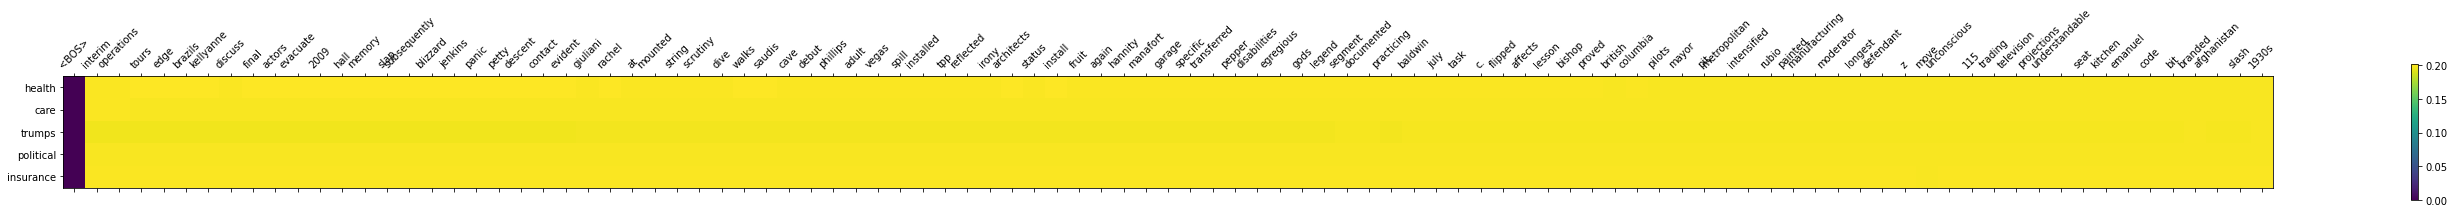

In [35]:
evaluateAndShowAttention(['health', 'care', 'trumps', 'political', 'insurance'], method='beam_search', is_sample=True)

In [36]:
def isnan(x):
    return x != x

for name, p in model.named_parameters():
#     if p.grad is None:
#         continue
    if p.requires_grad:
        print(name, p)
#         p.register_hook(lambda grad: torch.clamp(grad, -clip_value, clip_value))

Uf.weight Parameter containing:
tensor([[-1.9112e-02, -5.6622e-03,  2.1926e-02,  ..., -2.8710e-02,
         -3.6636e-02,  3.7454e-02],
        [-3.3823e-02, -8.7247e-05, -3.2633e-02,  ..., -2.0390e-02,
          1.7751e-02,  2.9828e-02],
        [ 1.9800e-02, -3.5939e-02, -2.4640e-02,  ...,  2.3913e-02,
         -2.6486e-02,  3.2324e-02],
        [-1.2615e-02,  4.4807e-03,  2.1322e-02,  ...,  1.3181e-02,
          6.0168e-03, -3.4168e-02],
        [ 2.6705e-02, -6.3359e-04, -3.0386e-02,  ...,  1.4182e-02,
         -3.4311e-02,  3.8309e-02]], device='cuda:0', requires_grad=True)
decoder.attention.Ua.weight Parameter containing:
tensor([[-0.0289,  0.0073, -0.0120,  ...,  0.0247, -0.0064, -0.0194],
        [ 0.0255,  0.0074, -0.0140,  ...,  0.0226,  0.0125,  0.0077],
        [ 0.0071, -0.0026,  0.0395,  ..., -0.0135, -0.0110,  0.0056],
        ...,
        [-0.0240, -0.0118,  0.0012,  ...,  0.0019,  0.0149, -0.0254],
        [ 0.0254,  0.0338,  0.0055,  ...,  0.0007,  0.0123, -0.0061],
  

In [37]:
def decay_lr(optimizer, epoch, factor=0.1, lr_decay_epoch=60):
    if epoch % lr_decay_epoch == 0:
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * factor
        print('lr decayed to %.4f' % optimizer.param_group[0]['lr'])
    return optimizer

## Train the model

In [46]:
since = time.time()
autograd.set_detect_anomaly(False)
prev_epoch = 0 if not epoch_values else epoch_values[-1]
best_bleu = 0 if not bleu_values else max(bleu_values)

for epoch in range(num_epoch - prev_epoch):
    epoch += prev_epoch
    start = time.time()
    num, total_loss = 0, 0
#     optimizer = decay_lr(optimizer=optimizer, epoch=epoch+1)
    topics_indice, corpus_indice = shuffleData(topics_indice, corpus_indice) # shuffle data at every epoch
    data = data_iterator(corpus_indice, topics_indice, batch_size, max(length) + 1)
    hidden = model.init_hidden(batch_size=batch_size)
    weight = torch.ones(len(vocab))
    weight[0] = 0
    num_iter = len(corpus_indice) // batch_size
    for X, Y, mask, topics in tqdm(data,total=num_iter):
        num += 1
#         hidden.detach_()
        if use_gpu:
            X = X.to(device)
            Y = Y.to(device)
            mask = mask.to(device)
            topics = topics.to(device)
#             hidden = hidden.to(device)
#             hidden[0].to(device)
#             hidden[1].to(device)
            loss_function = loss_function.to(device)
            weight = weight.to(device)
        optimizer.zero_grad()
        # init hidden layer
#         hidden = model.init_hidden(num_layers, batch_size, hidden_dim)
        coverage_vector = model.init_coverage_vector(batch_size, num_keywords)
        init_output = torch.zeros(batch_size, hidden_dim).to(device)
        # inputs, topics, output, hidden=None, mask=None, target=None, coverage_vector=None, seq_length=None):
        output, _, hidden, _, _ = model(inputs=X, topics=topics, output=init_output, hidden=hidden, mask=mask, target=Y, coverage_vector=coverage_vector)
#         output, hidden = model(X, topics)
        hidden[0].detach_()
        hidden[1].detach_()
        
        loss = (-output.output).reshape((-1, batch_size)).t() * mask
#         loss = loss.sum(dim=1)
        loss = loss.sum(dim=1) / mask.sum(dim=1)
        loss = loss.mean()
        loss.backward()
        
        norm = 0.0
#         norm = nn.utils.clip_grad_norm_(model.parameters(), 10)
        nn.utils.clip_grad_value_(model.parameters(), 1)
            
        optimizer.step()
        total_loss += float(loss.item())
        
        if np.isnan(total_loss):
            for name, p in model.named_parameters():
                if p.grad is None:
                    continue 
                print(name, p)
            assert False, "Gradient explode"
    
    one_iter_loss = np.mean(total_loss)
    lr_scheduler.step(one_iter_loss)
#     print("One iteration loss {:.3f}".format(one_iter_loss))
    
    # validation
    bleu_score = 0
    num_test = 500
    bleu_score = evaluate_bleu(model, topics_test, corpus_test, num_test=num_test, method='predict_rnn', is_sample=False)
    
    bleu_values.append(bleu_score)
    loss_values.append(total_loss / num)
    epoch_values.append(epoch+1)
    
    # save checkpoint
    if ((epoch + 1) % check_point == 0) or (epoch == (num_epoch - 1)) or epoch+1 > 90 or bleu_score > 4:
        model_check_point = '%s/model_trainable_%d.pk' % (save_folder, epoch+1)
        optim_check_point = '%s/optim_trainable_%d.pkl' % (save_folder, epoch+1)
        loss_check_point = '%s/loss_trainable_%d.pkl' % (save_folder, epoch+1)
        epoch_check_point = '%s/epoch_trainable_%d.pkl' % (save_folder, epoch+1)
        bleu_check_point = '%s/bleu_trainable_%d.pkl' % (save_folder, epoch+1)
        torch.save(model.state_dict(), model_check_point)
        torch.save(optimizer.state_dict(), optim_check_point)
        torch.save(loss_values, loss_check_point)
        torch.save(epoch_values, epoch_check_point)
        torch.save(bleu_values, bleu_check_point)
    
    # save current best result
    if bleu_score > best_bleu:
        best_bleu = bleu_score
        print('current best bleu: %.4f' % best_bleu)
        model_check_point = '%s/model_best_%d.pk' % (save_folder, epoch+1)
        optim_check_point = '%s/optim_best_%d.pkl' % (save_folder, epoch+1)
        loss_check_point = '%s/loss_best_%d.pkl' % (save_folder, epoch+1)
        epoch_check_point = '%s/epoch_best_%d.pkl' % (save_folder, epoch+1)
        bleu_check_point = '%s/bleu_best_%d.pkl' % (save_folder, epoch+1)
        torch.save(model.state_dict(), model_check_point)
        torch.save(optimizer.state_dict(), optim_check_point)
        torch.save(loss_values, loss_check_point)
        torch.save(epoch_values, epoch_check_point)
        torch.save(bleu_values, bleu_check_point)
        
    # calculate time
    end = time.time()
    s = end - since
    h = math.floor(s / 3600)
    m = s - h * 3600
    m = math.floor(m / 60)
    s -= (m * 60 + h * 3600)
    
    # verbose
    if ((epoch + 1) % verbose == 0) or (epoch == (num_epoch - 1)):
        print('epoch %d/%d, loss %.4f, norm %.4f, predict bleu: %.4f, time %.3fs, since %dh %dm %ds'
              % (epoch + 1, num_epoch, total_loss / num, norm, bleu_score, end - start, h, m, s))
        
        # evaluateAndShowAttention(['現在', '未來', '夢想', '科學', '文化'], method='beam_search', is_sample=False)
        


  0%|          | 0/3757 [00:00<?, ?it/s]


RuntimeError: ignored

In [ ]:
plt.plot(epoch_values, loss_values, 'b')
plt.title('loss vs. epoch')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
plt.plot(epoch_values, bleu_values, 'r')
plt.title('bleu vs. epoch')
plt.xlabel('epoch')
plt.ylabel('bleu score')
plt.show()

## Evaluation

In [ ]:
num_test = 5000
bleu_score = evaluate_bleu(model, topics_test, corpus_test, num_test=num_test, method='predict_rnn', is_sample=False)
bleu_score

## Test some samples

In [ ]:
evaluateAndShowAttention(['媽媽', '希望', '長大', '孩子', '母愛'], method='beam_search', is_sample=True)
evaluateAndShowAttention(['現在', '未來', '夢想', '科學', '文化'], method='beam_search', is_sample=True)
evaluateAndShowAttention(['春天', '來臨', '田野', '聆聽', '小路'], method='beam_search', is_sample=True)
evaluateAndShowAttention(['子女', '父母', '父愛', '無比', '溫暖'], method='beam_search', is_sample=True)
evaluateAndShowAttention(['信念', '人生', '失落', '心靈', '不屈'], method='beam_search', is_sample=True)
evaluateAndShowAttention(['體會', '母親', '滴水之恩', '母愛', '養育之恩'], method='beam_search', is_sample=True)